In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# --- Data Loading ---
print("=" * 80)
print("AIRBNB PRICE PREDICTION MODEL - LINEAR REGRESSION")
print("=" * 80)

try:
    df = pd.read_csv('../Data/listings_clean.csv')
    print(f"\n Dataset loaded successfully!")
    print(f"  Shape: {df.shape}")
except FileNotFoundError:
    print("\n Error: CSV not found.")
    # Create sample data for demonstration
    df = pd.DataFrame()

AIRBNB PRICE PREDICTION MODEL - LINEAR REGRESSION

 Dataset loaded successfully!
  Shape: (3506, 78)


In [7]:
# --- Feature Selection ---
print("\n" + "=" * 80)
print("FEATURE SELECTION")
print("=" * 80)

# Select features for modeling based on your cleaned dataset
numeric_features = [
    # Original features
    'accommodates', 
    'bedrooms', 
    'bathrooms', 
    'beds',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews',
    'number_of_reviews_ltm',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'latitude', 
    'longitude',
    'host_listings_count',
    'host_total_listings_count',
    'availability_365',
    'reviews_per_month',
    'host_tenure_years',
    'days_since_last_review',
    'listing_age_years',
    'n_amenities',
    'host_response_rate',
    'host_acceptance_rate',
    # Engineered features
    'price_per_person',
    'bedroom_ratio',
    'bathroom_ratio',
    'bed_shortage',
    'reviews_per_year',
    'review_recency_score',
    'host_experience_score',
    'availability_score',
    'avg_review_score',
    'amenity_density',
    'key_amenities_score',
    'luxury_score',
    'distance_from_center',
    'is_entire_place',
    'stay_flexibility',
    'host_quality_score',
    'property_size_score',
    'review_trust_score'
]

categorical_features = [
    'room_type', 
    'property_type',
    'neighbourhood_cleansed',
    'host_response_time'
]

boolean_features = [
    'host_is_superhost', 
    'host_has_profile_pic',
    'host_identity_verified',
    'instant_bookable',
    'amenity_wifi',
    'amenity_kitchen',
    'amenity_parking',
    'amenity_heating',
    'amenity_ac',
    'amenity_tv',
    'amenity_washer',
    'amenity_dryer',
    'amenity_dishwasher',
    'amenity_free_street_parking',
    'amenity_private_entrance',
    'amenity_dedicated_workspace',
    'amenity_self_checkin',
    'amenity_pets_allowed',
    'amenity_bathtub'
]

# Filter to only include features that exist in the dataset
numeric_features = [f for f in numeric_features if f in df.columns]
categorical_features = [f for f in categorical_features if f in df.columns]
boolean_features = [f for f in boolean_features if f in df.columns]

all_features = numeric_features + categorical_features + boolean_features

print(f"\nSelected features for modeling:")
print(f"  Numeric: {len(numeric_features)} features")
print(f"  Categorical: {len(categorical_features)} features")
print(f"  Boolean: {len(boolean_features)} features")
print(f"  Total: {len(all_features)} features")


FEATURE SELECTION

Selected features for modeling:
  Numeric: 27 features
  Categorical: 4 features
  Boolean: 19 features
  Total: 50 features


In [28]:
# --- Data Prep ---
print("\n" + "=" * 80)
print("PREPARING DATA FOR MODELING")
print("=" * 80)

# Create feature matrix X and target vector y
X = df[all_features].copy()
y = df['price'].copy()

# Check for missing values
print(f"\nMissing values in features:")
missing_counts = X.isnull().sum()
missing_features = missing_counts[missing_counts > 0]
if len(missing_features) > 0:
    print(missing_features)
else:
    print("  No missing values found!")

print(f"\nMissing values in target (price): {y.isnull().sum()}")

# Handle missing values
# For numeric features: fill with median
for col in numeric_features:
    if col in X.columns and X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

# For categorical features: fill with 'Unknown'
for col in categorical_features:
    if col in X.columns and X[col].isnull().any():
        X[col] = X[col].fillna('Unknown')

# For boolean features: fill with False
for col in boolean_features:
    if col in X.columns and X[col].isnull().any():
        X[col] = X[col].fillna(False)

# Remove rows where target (price) is missing
valid_mask = y.notna()
X = X[valid_mask]
y = y[valid_mask]

print(f"\n Missing values handled")
print(f"  Shape after handling missing values: X={X.shape}, y={y.shape}")

# Check for any remaining NaN or infinite values
print(f"\nChecking for invalid values:")
print(f"  NaN in X: {X.isnull().sum().sum()}")
print(f"  Inf in X: {np.isinf(X.select_dtypes(include=[np.number])).sum().sum()}")

# Replace any infinite values with NaN, then fill with median
X = X.replace([np.inf, -np.inf], np.nan)
for col in numeric_features:
    if col in X.columns and X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

# Remove extreme outliers in price (above 99th percentile)
price_threshold = y.quantile(0.99)
mask = y <= price_threshold
X = X[mask]
y = y[mask]

# Remove extremely low prices that might be data errors
price_floor = 10  # Minimum realistic price per night
mask_floor = y >= price_floor
X = X[mask_floor]
y = y[mask_floor]

print(f"\n Feature matrix prepared")
print(f"  Total features: {len(all_features)} ({len(numeric_features)} numeric, {len(categorical_features)} categorical, {len(boolean_features)} boolean)")
print(f"  Shape after outlier removal: X={X.shape}, y={y.shape}")
print(f"  Price range: ${y.min():.2f} - ${y.max():.2f}")
print(f"  Price threshold (99th percentile): ${price_threshold:.2f}")

# Train-test-validation split
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Second split: split temp into 50-50 (15% val, 15% test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"\n Train-validation-test split completed (70-15-15)")
print(f"  Training set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")


PREPARING DATA FOR MODELING

Missing values in features:
beds                             1
review_scores_rating           727
review_scores_accuracy         727
review_scores_cleanliness      727
review_scores_checkin          727
review_scores_communication    727
review_scores_location         727
review_scores_value            727
host_listings_count              1
host_total_listings_count        1
reviews_per_month              727
host_tenure_years                1
days_since_last_review         727
listing_age_years              727
host_response_rate             143
host_acceptance_rate           142
host_response_time             143
host_is_superhost              203
host_has_profile_pic             1
host_identity_verified           1
dtype: int64

Missing values in target (price): 0

 Missing values handled
  Shape after handling missing values: X=(3506, 50), y=(3506,)

Checking for invalid values:
  NaN in X: 0
  Inf in X: 0

 Feature matrix prepared
  Total features: 50

In [ ]:
# --- Data Preprocessing ---
print("\n" + "=" * 80)
print("BUILDING PREPROCESSING PIPELINE")
print("=" * 80)

# Create preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("\n Preprocessing pipeline created")
print("  - Numeric features: StandardScaler")
print("  - Categorical features: OneHotEncoder")
print("  - Boolean features: Passthrough")


BUILDING PREPROCESSING PIPELINE

 Preprocessing pipeline created
  - Numeric features: StandardScaler
  - Categorical features: OneHotEncoder
  - Boolean features: Passthrough


In [25]:
# --- Training ---
print("\n" + "=" * 80)
print("TRAINING REGRESSION MODEL")
print("=" * 80)

# Linear
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
print("\nTraining in progress...")
model_pipeline.fit(X_train, y_train)
print(" Model training completed!")

# Ridge
# from sklearn.linear_model import Ridge

# # Create full pipeline with Ridge model
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('regressor', Ridge(alpha=1.0, random_state=42))  # alpha controls regularization strength
# ])

# # Train the model
# print("\nTraining Ridge Regression with regularization...")
# print("  Alpha (regularization strength): 1.0")
# model_pipeline.fit(X_train, y_train)
# print(" Model training completed!")

# Lasso
# from sklearn.linear_model import Lasso

# # Create full pipeline with Lasso model
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('regressor', Lasso(alpha=1.0, random_state=42, max_iter=10000))  # Lasso does feature selection
# ])

# # Train the model
# print("\nTraining Lasso Regression with L1 regularization...")
# print("  Alpha (regularization strength): 1.0")
# print("  Lasso will automatically select important features")
# model_pipeline.fit(X_train, y_train)
# print(" Model training completed!")

# # Check which features were selected (non-zero coefficients)
# coefficients = model_pipeline.named_steps['regressor'].coef_
# feature_names = (numeric_features + 
#                 list(model_pipeline.named_steps['preprocessor']
#                      .named_transformers_['cat']
#                      .get_feature_names_out(categorical_features)) +
#                 boolean_features)
# non_zero_features = np.sum(coefficients != 0)
# print(f"\n Feature selection completed:")
# print(f"  Total features: {len(coefficients)}")
# print(f"  Non-zero features: {non_zero_features}")
# print(f"  Features eliminated: {len(coefficients) - non_zero_features}")


TRAINING REGRESSION MODEL

Training in progress...
 Model training completed!


In [26]:
# --- Model Evaluation ---
print("\n" + "=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

# Make predictions
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n TRAINING SET PERFORMANCE:")
print(f"  MAE:  ${train_mae:.2f}")
print(f"  RMSE: ${train_rmse:.2f}")
print(f"  R²:   {train_r2:.4f}")

print("\n TEST SET PERFORMANCE:")
print(f"  MAE:  ${test_mae:.2f}")
print(f"  RMSE: ${test_rmse:.2f}")
print(f"  R²:   {test_r2:.4f}")



MODEL EVALUATION

 TRAINING SET PERFORMANCE:
  MAE:  $430.78
  RMSE: $908.24
  R²:   0.9034

 TEST SET PERFORMANCE:
  MAE:  $488.48
  RMSE: $892.62
  R²:   0.8685



GENERATING VISUALIZATIONS

 Visualizations saved as 'model_evaluation.png'


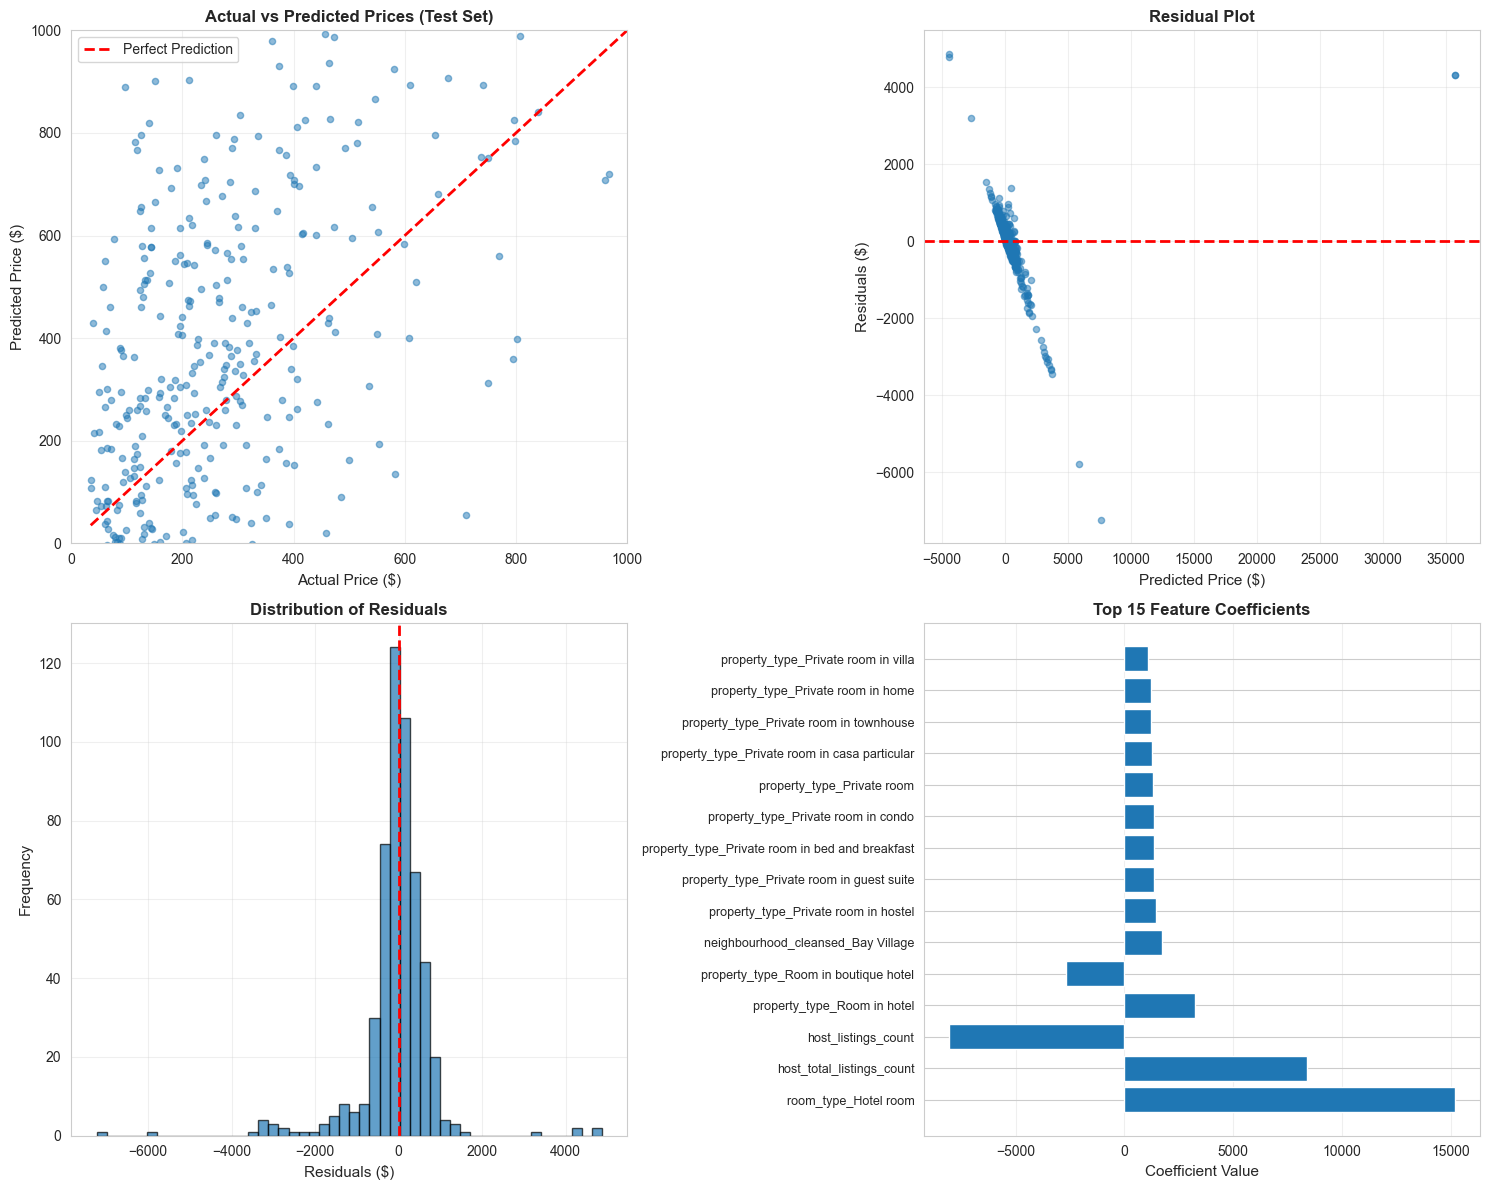

In [27]:
# --- Visualizations ---
print("\n" + "=" * 80)
print("GENERATING VISUALIZATIONS")
print("=" * 80)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.5, s=20)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlim(0, 1000)
axes[0, 0].set_ylim(0, 1000)
axes[0, 0].set_xlabel('Actual Price ($)', fontsize=11)
axes[0, 0].set_ylabel('Predicted Price ($)', fontsize=11)
axes[0, 0].set_title('Actual vs Predicted Prices (Test Set)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual Plot
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.5, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Price ($)', fontsize=11)
axes[0, 1].set_ylabel('Residuals ($)', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution of Residuals
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals ($)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature Importance (Coefficients)
# Get feature names after preprocessing
feature_names = (numeric_features + 
                list(model_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_features)) +
                boolean_features)

coefficients = model_pipeline.named_steps['regressor'].coef_
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False).head(15)

axes[1, 1].barh(range(len(coef_df)), coef_df['Coefficient'])
axes[1, 1].set_yticks(range(len(coef_df)))
axes[1, 1].set_yticklabels(coef_df['Feature'], fontsize=9)
axes[1, 1].set_xlabel('Coefficient Value', fontsize=11)
axes[1, 1].set_title('Top 15 Feature Coefficients', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
print("\n Visualizations saved as 'model_evaluation.png'")
plt.show()

In [29]:
# --- Sample Predictions ---
print("\n" + "=" * 80)
print("SAMPLE PREDICTIONS")
print("=" * 80)

# Show some sample predictions
sample_indices = np.random.choice(X_test.index, size=5, replace=False)
samples = X_test.loc[sample_indices]
actual_prices = y_test.loc[sample_indices]
predicted_prices = model_pipeline.predict(samples)

print("\nRandom sample predictions from test set:")
print("-" * 80)
for i, (idx, actual, predicted) in enumerate(zip(sample_indices, actual_prices, predicted_prices), 1):
    error = abs(actual - predicted)
    error_pct = (error / actual) * 100
    print(f"\nSample {i}:")
    print(f"  Actual Price:    ${actual:.2f}")
    print(f"  Predicted Price: ${predicted:.2f}")
    print(f"  Error:           ${error:.2f} ({error_pct:.1f}%)")


SAMPLE PREDICTIONS

Random sample predictions from test set:
--------------------------------------------------------------------------------

Sample 1:
  Actual Price:    $608.00
  Predicted Price: $482.26
  Error:           $125.74 (20.7%)

Sample 2:
  Actual Price:    $78.00
  Predicted Price: $-372.15
  Error:           $450.15 (577.1%)

Sample 3:
  Actual Price:    $553.00
  Predicted Price: $612.21
  Error:           $59.21 (10.7%)

Sample 4:
  Actual Price:    $158.00
  Predicted Price: $175.28
  Error:           $17.28 (10.9%)

Sample 5:
  Actual Price:    $79.00
  Predicted Price: $132.93
  Error:           $53.93 (68.3%)
